In [1]:
import os
import pickle
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter

from config import (dta_dir,
                    figure_dir,
                    derived_dir)

In [2]:
def process_data(fname):
    
    l12 = pd.read_csv(dta_dir + fname)
    l12 = l12.rename(columns = {'Unnamed: 0':'symptom'})
    l12 = l12.loc[~l12.symptom.isin(['rash'])]
    
    labeldict = pickle.load(open(derived_dir + 'labeldict.pkl','rb'))
    l12.symptom = l12.symptom.map(labeldict)
    
    l12 = l12.set_index('symptom')
    
    cols = pd.read_csv(derived_dir + 'sorted_columns_core.csv',index_col=0)
    l12 = l12.T[[c for c in cols['0'].values if c in l12.T.columns]]
    
    return l12.T

In [3]:
f = 'lr_results_0_1_core_.csv'
l12 = process_data(f)

In [4]:
f = 'lr_results_0_2_core_.csv'
g12 = process_data(f)

In [5]:
def forest_plot(results, color, ax, label='',shift=False):
    
    results = results.reindex(index=results.index[::-1])
    
    ax.plot(np.ones(results.shape[0]), pd.Series(results.index), 'k--', alpha=0.6)
    
    lerr = results.Estimate - results['2.5 %']
    herr = results['97.5 %'] - results.Estimate 
    errs = np.array(list(zip(lerr.values,
                             herr.values))).T
    
    if shift:
        ax.errorbar(x=results.Estimate, y=results.y_shift,
                    xerr=errs, fmt = '.', 
                    color = color,
                    alpha=0.9,
                    lw=2,
                    ms=7, label=label)
    else:    
        ax.errorbar(x=results.Estimate, y=results.index,
                    xerr=errs, fmt = '.', 
                    color = color,
                    alpha=0.9,
                    lw=2,
                    ms=7)
    
    ax.set_xscale('log',base=10)
    ax.grid(alpha=0.2)
    
    return ax

## Final figure 

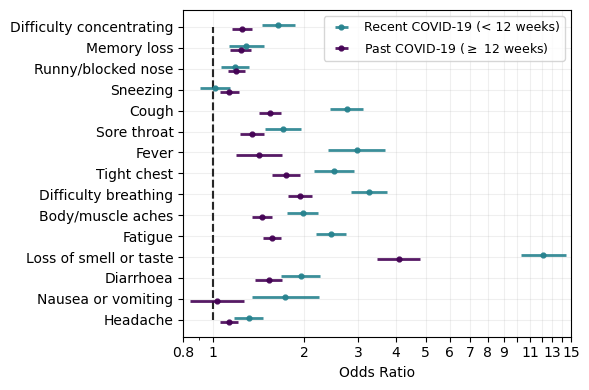

In [6]:
fig,ax = plt.subplots(figsize=(6,4))

n_cols = 10
cmap = mpl.colormaps['viridis_r']
colors = cmap(np.linspace(0, 1, n_cols))

l12['y_shift'] = [i+0.1 for i in np.arange(l12.shape[0]-1,-1,-1)]
g12['y_shift'] = [i-0.1 for i in np.arange(l12.shape[0]-1,-1,-1)]
ax = forest_plot(l12,colors[5],ax, label='Recent COVID-19 (< 12 weeks)', shift=True)
ax = forest_plot(g12,colors[9],ax, label='Past COVID-19 ($\geq$ 12 weeks)', shift=True)

ax.set_xlabel('Odds Ratio')

formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax.xaxis.set_major_formatter(formatter)

ticks = np.insert(np.arange(1,20, dtype=float),0,0.8,axis=0)
labels=[int(l) if l>0.8 else l for l in ticks]

ax.set_xticks(ticks, labels, fontsize=10)
ax.set_xlim(0.8,15)

xticks = ax.xaxis.get_major_ticks()

for tick in xticks[10::2]:
    tick.label1.set_visible(False)


ax.legend(loc='upper right', fontsize=9, alignment='right',
         frameon=True)

plt.tight_layout()

plt.savefig(figure_dir + 'symptom_ors.pdf')
plt.savefig(figure_dir + 'symptom_ors.png',dpi=300, bbox_inches="tight",pad_inches=0.5 )

## Table 

In [7]:
table = pd.DataFrame(index = l12.index)

In [8]:
l12.rename(columns = {'2.5 %': 'low_ci',
                      '97.5 %': 'hi_ci'}, inplace=True)

table['l12 OR'] = l12.Estimate
table['l12 95% CI'] = [f'[{round(v,2)}, {round(l12.hi_ci.values[i],2)}]'
                      for i,v in enumerate(l12.low_ci.values)]

table['l12 p-value'] = l12['Pr(>|z|)'].round(3)

In [9]:
g12.rename(columns = {'2.5 %': 'low_ci',
                      '97.5 %': 'hi_ci'}, inplace=True)

table['g12 OR'] = g12.Estimate
table['g12 95% CI'] = [f'[{round(v,2)}, {round(g12.hi_ci.values[i],2)}]'
                      for i,v in enumerate(g12.low_ci.values)]

table['g12 p-value'] = g12['Pr(>|z|)'].round(3)

In [10]:
table = table.replace(0.000, '<0.001')

In [11]:
table

,l12 OR,l12 95% CI,l12 p-value,g12 OR,g12 95% CI,g12 p-value
symptom,,,,,,
Difficulty concentrating,1.642581,"[1.45, 1.86]",<0.001,1.248864,"[1.16, 1.35]",<0.001
Memory loss,1.290448,"[1.13, 1.48]",<0.001,1.234113,"[1.14, 1.34]",<0.001
Runny/blocked nose,1.181901,"[1.06, 1.31]",0.002,1.195441,"[1.12, 1.28]",<0.001
Sneezing,1.017371,"[0.91, 1.14]",0.77,1.132116,"[1.05, 1.22]",0.001
Cough,2.754416,"[2.43, 3.12]",<0.001,1.542742,"[1.42, 1.68]",<0.001
Sore throat,1.701072,"[1.49, 1.95]",<0.001,1.344797,"[1.23, 1.47]",<0.001
Fever,2.964515,"[2.4, 3.66]",<0.001,1.417484,"[1.19, 1.69]",<0.001
Tight chest,2.506351,"[2.16, 2.91]",<0.001,1.740108,"[1.56, 1.94]",<0.001
Difficulty breathing,3.257432,"[2.83, 3.74]",<0.001,1.934634,"[1.76, 2.12]",<0.001


In [12]:
table.to_csv(figure_dir + 'symptom_OR_table.csv')